In [23]:
import Get_data as Gd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


directory = '..\\data\\Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]
train_set, length = Gd.get_all_data(folders[:-2])
train_set = train_set[:, :, 0]


In [2]:
train_set.shape

(2800, 97149)

In [3]:
preprocessor = Gd.Preprocessor(train_set, n_components=50)
preprocessor.fit()
train_set = preprocessor.transform(train_set)
train_set = Gd.data_panelling(train_set, length, step_size=5)

train_x = train_set[:, 0:5, :]
train_y = train_set[:, 5:, :]

8.505847806583544


In [4]:
train_set.shape

(532, 10, 50)

In [5]:
test_set, length = Gd.get_all_data(folders[-2:])
test_set = test_set[:, :, 0]
test_set_real = Gd.data_panelling(test_set, length, step_size=5)

test_set = preprocessor.transform(test_set)
test_set = Gd.data_panelling(test_set, length, step_size=5)

test_x = test_set[:, 0:5, :]
test_y = test_set[:, 5:, :]

test_real_x = test_set_real[:, 0:5, :]
test_real_y = test_set_real[:, 5:, :]

7.3066695717952


In [6]:
test_set_real[0, :, :].shape

(10, 97149)

In [7]:
train_tenser_set = Gd.MyDataset(train_x, train_y)
test_tenser_set = Gd.MyDataset(test_x, test_y)
test_real_tenser_set = Gd.MyDataset(test_real_x, test_real_y)

In [8]:
train_loader = DataLoader(train_tenser_set, batch_size=10, shuffle=True)
test_loader = DataLoader(test_tenser_set, batch_size=1, shuffle=False)
test_real_loader = DataLoader(test_real_tenser_set, batch_size=1, shuffle=False)

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.sigmoid = nn.Sigmoid()
        
        self.W_xi = nn.Linear(input_size, hidden_size, bias=True)
        self.W_hi = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.W_xf = nn.Linear(input_size, hidden_size, bias=True)
        self.W_hf = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.W_xo = nn.Linear(input_size, hidden_size, bias=True)
        self.W_ho = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.W_xc = nn.Linear(input_size, hidden_size, bias=True)
        self.W_hc = nn.Linear(hidden_size, hidden_size, bias=True)
        
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size), torch.zeros(batch_size, self.hidden_size)
    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        h_t, c_t = self.init_hidden(batch_size)
        for t in range(seq_len):
            x_t = x[:, t, :]
            
            i_t = self.sigmoid(self.W_xi(x_t)+self.W_hi(h_t))
            f_t = self.sigmoid(self.W_xf(x_t)+self.W_hf(h_t))
            o_t = self.sigmoid(self.W_xo(x_t)+self.W_ho(h_t))
            g_t = torch.tanh(self.W_xc(x_t)+self.W_hc(h_t))
            
            c_t = f_t*c_t+i_t*g_t
            h_t = o_t * torch.tanh(c_t)
        
        return h_t, c_t
            
        
        
        

In [10]:
class Decoder(nn.Module):
    def __init__(self, hidden_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = hidden_size
        
        self.sigmoid = nn.Sigmoid()
        
        self.W_xi = nn.Linear(hidden_size, hidden_size, bias=True)
        self.W_hi = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.W_xf = nn.Linear(hidden_size, hidden_size, bias=True)
        self.W_hf = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.W_xo = nn.Linear(hidden_size, hidden_size, bias=True)
        self.W_ho = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.W_xc = nn.Linear(hidden_size, hidden_size, bias=True)
        self.W_hc = nn.Linear(hidden_size, hidden_size, bias=True)
        
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size), torch.zeros(batch_size, self.hidden_size)
    
    def forward(self, x, expected_seq_len):
        batch_size = x.shape[0]
        h_t, c_t = self.init_hidden(batch_size)
        output = []
        for t in range(expected_seq_len):
            
            i_t = self.sigmoid(self.W_xi(x)+self.W_hi(h_t))
            f_t = self.sigmoid(self.W_xf(x)+self.W_hf(h_t))
            o_t = self.sigmoid(self.W_xo(x)+self.W_ho(h_t))
            g_t = torch.tanh(self.W_xc(x)+self.W_hc(h_t))
            
            c_t = f_t*c_t+i_t*g_t
            h_t = o_t * torch.tanh(c_t)
            
            output.append(h_t.unsqueeze(1))
        output = torch.cat(output, dim=1)
        return output
        

In [11]:
class Seq2Seq(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Seq2Seq, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = input_dim
        
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = Decoder(hidden_dim)
        self.linear = nn.Linear(hidden_dim, self.output_dim)
        
        self.relu = nn.ReLU()
    
    def forward(self, x, expected_seq_len = 5):
        h_t, _ = self.encoder(x)
        output = self.decoder(h_t, expected_seq_len)
        
        output = self.relu(self.linear(output))
        
        return output
        

In [12]:
from torchsummary import summary
model = Seq2Seq(input_dim=50, hidden_dim=100)
summary = summary(model, input_size=(1, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]           5,100
            Linear-2                  [-1, 100]          10,100
           Sigmoid-3                  [-1, 100]               0
            Linear-4                  [-1, 100]           5,100
            Linear-5                  [-1, 100]          10,100
           Sigmoid-6                  [-1, 100]               0
            Linear-7                  [-1, 100]           5,100
            Linear-8                  [-1, 100]          10,100
           Sigmoid-9                  [-1, 100]               0
           Linear-10                  [-1, 100]           5,100
           Linear-11                  [-1, 100]          10,100
          Encoder-12     [[-1, 100], [-1, 100]]               0
           Linear-13                  [-1, 100]          10,100
           Linear-14                  [

In [13]:
def train(model, train_loader, optimizer, criterion, epochs=100):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(y, output)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch + 1}/{epochs}, train Loss: {total_loss / len(train_loader)}')

In [14]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))
model = Seq2Seq(input_dim=50, hidden_dim=50)
optimizer = optim.Adam(model.parameters())

In [15]:
train(model, train_loader, optimizer, criterion=RMSELoss())

Epoch 1/100, train Loss: 0.993183700022874
Epoch 2/100, train Loss: 0.9843458356680693
Epoch 3/100, train Loss: 0.9445599201652739
Epoch 4/100, train Loss: 0.9387302420757435
Epoch 5/100, train Loss: 0.9103189963433478
Epoch 6/100, train Loss: 0.8916825354099274
Epoch 7/100, train Loss: 0.8902258541848924
Epoch 8/100, train Loss: 0.8749657251216747
Epoch 9/100, train Loss: 0.8690828531980515
Epoch 10/100, train Loss: 0.866348812425578
Epoch 11/100, train Loss: 0.849865957542702
Epoch 12/100, train Loss: 0.8560096268300657
Epoch 13/100, train Loss: 0.8564919122943172
Epoch 14/100, train Loss: 0.853517414243133
Epoch 15/100, train Loss: 0.8402739073391314
Epoch 16/100, train Loss: 0.83512908772186
Epoch 17/100, train Loss: 0.8383105949119285
Epoch 18/100, train Loss: 0.8263531145122316
Epoch 19/100, train Loss: 0.838313118175224
Epoch 20/100, train Loss: 0.826764616701338
Epoch 21/100, train Loss: 0.8197538830615856
Epoch 22/100, train Loss: 0.8248270860424748
Epoch 23/100, train Loss: 0

In [16]:
def test(model, test_loader, test_real_loader, criterion, preprocessor):
    model.eval()
    latent_err = 0
    recon_err = 0
    with torch.no_grad():
        for (x, y), (x_r, y_r) in zip(test_loader, test_real_loader):
            output = model(x)
            latent_err += criterion(y, output).item()
            
            recon_output = preprocessor.inverse_transform(output.detach().numpy().squeeze())
            y_r_np = y_r.detach().numpy().squeeze()
            recon_err += mean_squared_error(y_r_np, recon_output)
        
        return latent_err/len(test_loader), recon_err/len(test_real_loader)
            

In [17]:
test(model, test_loader, test_real_loader, criterion=RMSELoss(), preprocessor=preprocessor)

(1.2522535473108292, 86.88603819596494)

In [19]:
input, _ = test_tenser_set[0, :, :]


torch.Size([5, 50])

In [31]:
def draw_pic(model, input, label, real_output, coords):
    output = model(input)
    recon_output = preprocessor.inverse_transform(output.detach().numpy().squeeze()) # (5, 97149)
    recon_label = preprocessor.inverse_transform(label.detach().numpy().squeeze())
    
    fig1, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = marker_size, c=recon_output[i, :], cmap='bwr')
    plt.show()
    plt.close()
    
    fig2, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = marker_size, c=recon_label[i, :], cmap='bwr')
    plt.show()
    plt.close()
    
    real = real_output.detach().numpy().squeeze()
    fig3, axs = plt.subplots(1, 5, figsize=(30, 6))
    
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = marker_size, c=real[i, :], cmap='bwr')
    plt.show()
    plt.close()
    


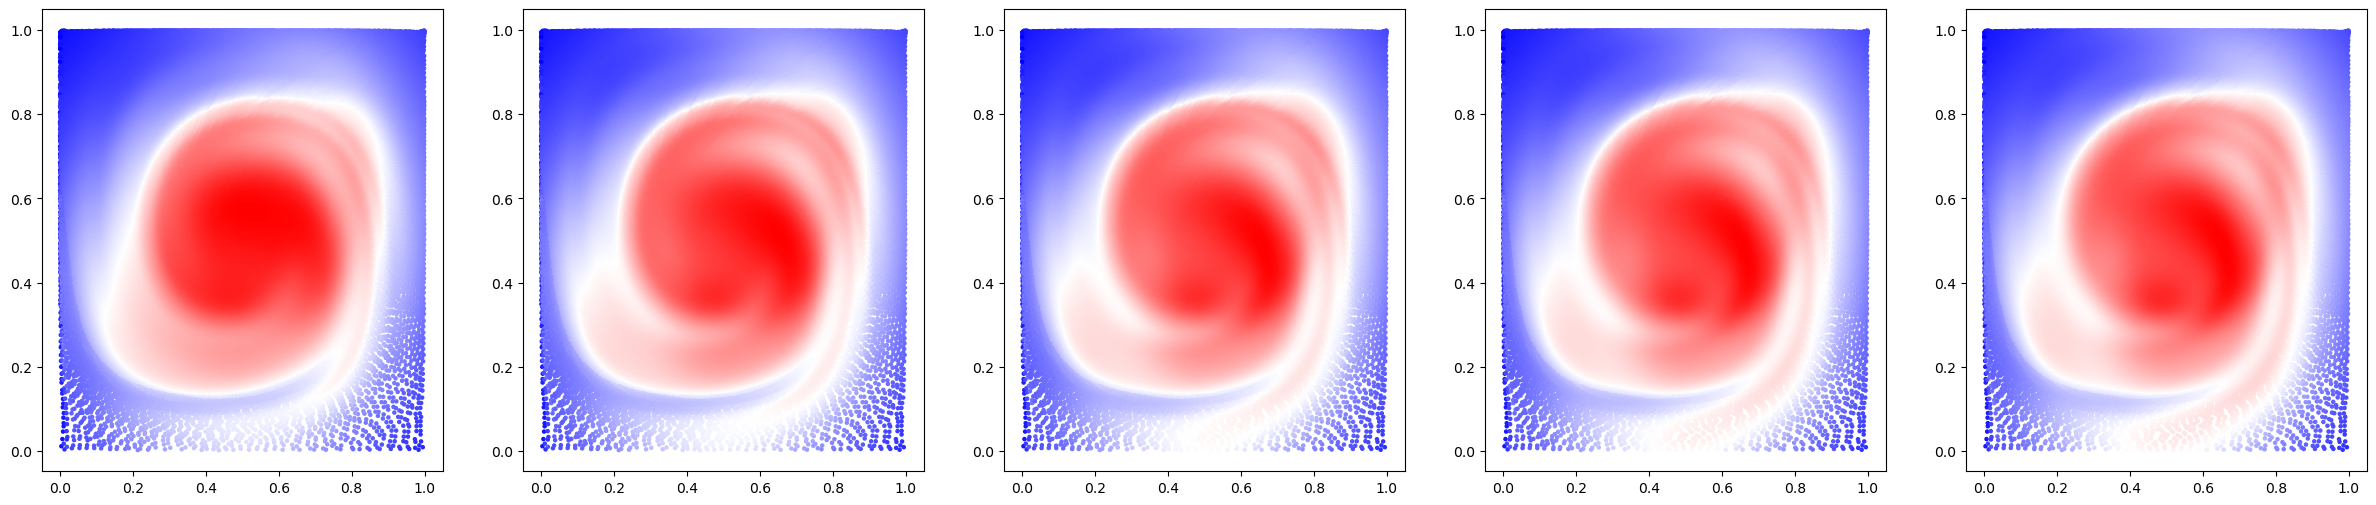

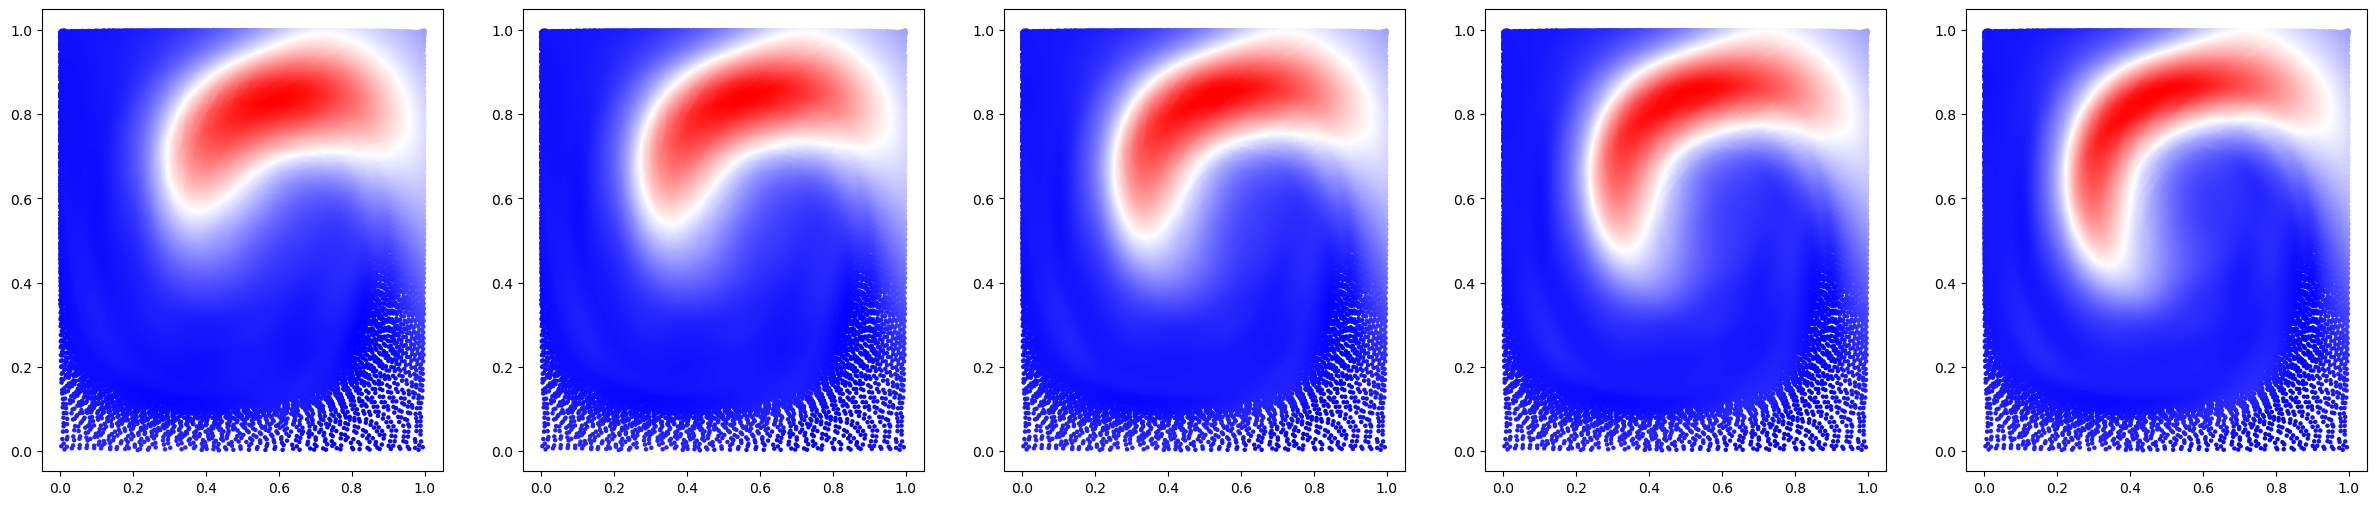

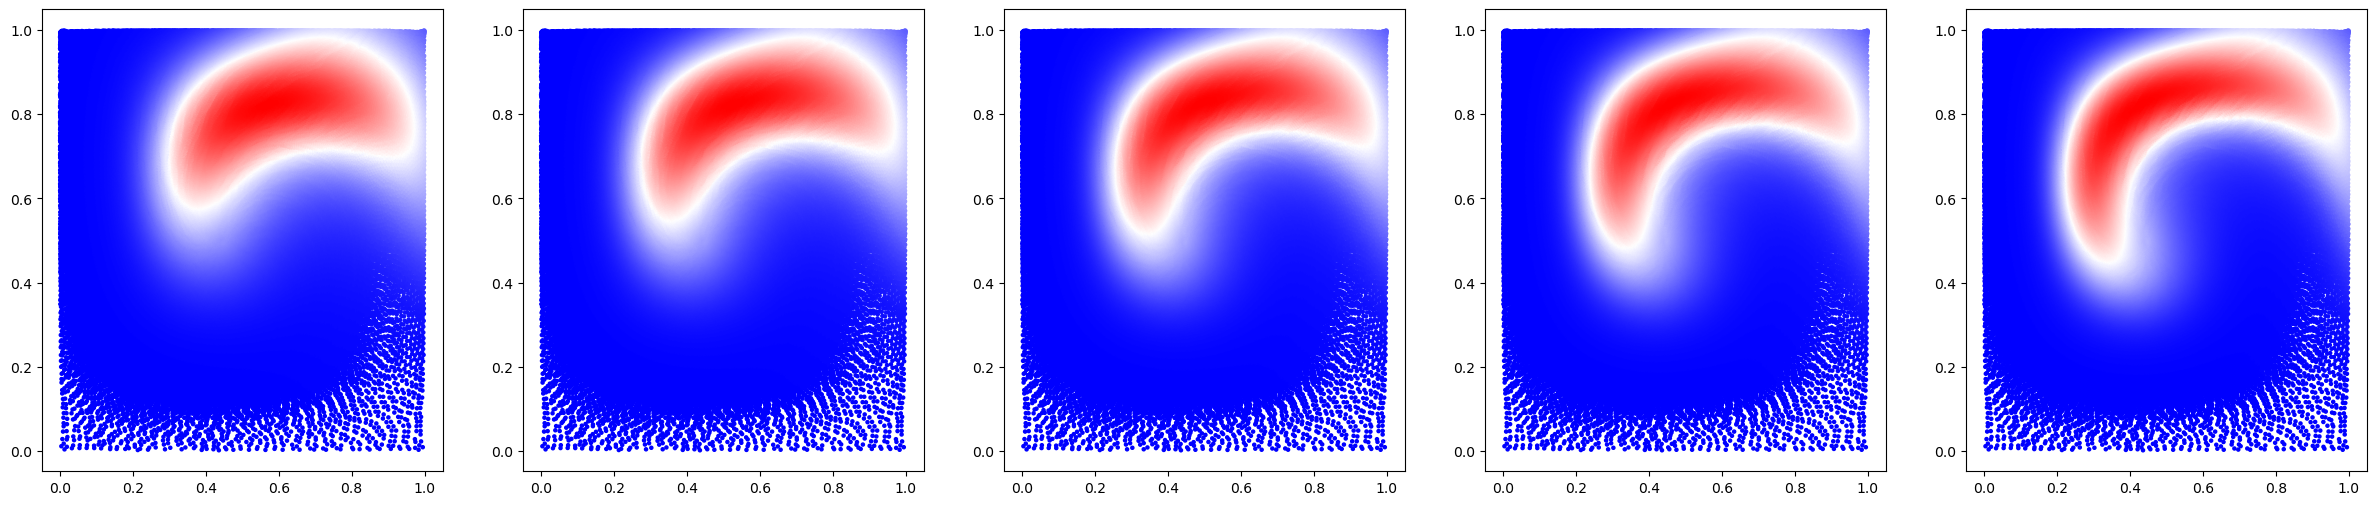

In [32]:


xyfile = "..\\data\Sibo_22Mar2024\\case_0\hessian_\\xy_coords.npy"
marker_size = 5 #upped this to make points more visible
# load the file
xycoords_check = np.load(xyfile)

input, label = test_tenser_set[0, :, :]
input = input.unsqueeze(0)
_, real_output = test_real_tenser_set[0, :, :]
real_output = real_output.unsqueeze(0)

draw_pic(model, input, label, real_output, xycoords_check)

